In [1]:
!pip install colab-xterm
%load_ext colabxterm

# Warning
To execute this notebook at least 16 Go of RAM is advised

# Setting up ollama
For the first xterm:
- curl https://ollama.ai/install.sh | sh
- ollama serve &

In [2]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

Second xterm:
- ollama pull gemma3:4b

> small model to run even on CPU with correct compute time

In [3]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [4]:
!pip install ollama

In [5]:
import networkx as nx
import numpy as np
from collections import defaultdict
import random

In [6]:
import pandas as pd
from LinkPredictor import EnhancedLinkPredictor
import networkx as nx
import numpy as np
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import unicodedata
from sklearn.decomposition import LatentDirichletAllocation
import ast
import torch
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
df = pd.read_csv('data/dblp_papers_2020_sample_with_refs.csv', sep=';')#pd.read_csv('dblp_processing/dblp_papers_2020_SampleWithRefs.csv', sep=';')
df['abstract'] = df['abstract'].fillna('')
df['references'] = df['references'].apply(ast.literal_eval)
df.head()

,id,title,year,references,abstract
0,3005773274,Malware classification algorithm using advance...,2020.0,[],"Recently, Internet of Drones (IoD) are issu..."
1,3002219790,Generalized transitivity: A systematic compari...,2020.0,"[79079207, 170687150, 756957829, 1517040319, 1...",Reciprocal relations are binary relations Q...
2,2999570098,A New DGNSS Positioning Infrastructure for And...,2020.0,"[1978255623, 2109436662, 2146023544, 218050761...",One’s position has become an important piece o...
3,2998778732,A New Cycle Slip Detection and Repair Method U...,2020.0,[2482503770],The detection and repair of the cycle slip is ...
4,2972569439,Existence and concentration of positive ground...,2020.0,[],This paper is concerned with the following ...


In [8]:
# reduce the dataset size for faster compute
def reduce_dataset_size(df, ratio_delete=0.95):
  """
    @brief:
      Reduce the size of the dataset while keeping the graph coherent (e.g. all core articles have their references within the graph)
    @params:
      df: input dataset in a dataframe
      ratio_delete: ratio of the dataset to delete
    @returns:
      df: reduced dataset
  """
  empty_ref = []
  for idx, row in df.iterrows():
    if row['references'] == []:
      df.drop(idx, inplace=True)
      empty_ref.append(row)
  empty_df = pd.DataFrame(empty_ref)
  print("Number of core articles", len(df))

  ratio_delete = 0.95
  nb_to_delete = len(df) * ratio_delete
  nb_delete = 0
  for idx, row in df.iterrows():
    if len(row['references']) > 0 and nb_delete < nb_to_delete:
      df.drop(idx, inplace=True)
      nb_delete += 1
  for idx, row in df.iterrows():
    for r in row['references']:
      is_ref_in_df = df[df['id'] == r]
      if is_ref_in_df.empty:
        df = pd.concat([df, empty_df[empty_df['id'] == r]])
  print("Final size of the dataset", len(df))
  return df

In [9]:
df = reduce_dataset_size(df)

Number of core articles 75
Final size of the dataset 74


In [10]:
df.head()

,id,title,year,references,abstract
93,2972653537,Global and Local Multi-View Multi-Label Learning,2020.0,"[221337630, 1201875361, 1978169406, 2002370809...",In order to process multi-view multi-label ...
95,2992197405,An IoT platform for the analysis of brain CT i...,2020.0,"[1951747108, 1970150866, 2044465660, 209405627...",Stroke or cerebrovascular accidents are amo...
98,3000392525,Inertial sensors-based torso motion mode recog...,2020.0,"[1540557062, 1913582850, 1978332670, 214478157...",ABSTRACTIn order to achieve high-level control...
111,221337630,Multi-view based multi-label propagation for i...,2015.0,[],Multi-view learning and multi-label propagatio...
126,1201875361,Multi-view low-rank dictionary learning for im...,2016.0,[],"Recently, a multi-view dictionary learning (DL..."


In [11]:
print('Expected number of edges in graph:',df['references'].apply(len).sum())

Expected number of edges in graph: 71


In [12]:
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from CitationGraphAbstractGenerator import CitationGraphAbstractGenerator


In [13]:
# Create sample papers with abstracts and references
papers = df.to_dict(orient='records')

# Initialize the generator
generator = CitationGraphAbstractGenerator()

# Load citation graph
generator.load_citation_graph(papers)

# Compute embeddings for existing papers
generator.compute_embeddings()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Graph created with 74 nodes and 71 edges


Computing embeddings: 100%|██████████| 74/74 [00:19<00:00,  3.77it/s]

Embeddings computed for all nodes


In [18]:
import gc
gc.collect()

20848

In [15]:
# Create a new node, x min to upgrade the abstract
new_node_id = generator.create_new_node()

Community detection failed: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001. Using uniform scores.
Added 4 links from node new_paper_0
Error generating abstract: model requires more system memory (5.9 GiB) than is available (5.4 GiB) (status code: 500)
Generated abstract with 7 key concepts: simulated, sale, approach, approach variety, approach variety topics, approach variety topics resulting, approach variety topics resulting results
Created new node new_paper_0 which has as reference [2169491762, 2168822268, 2167221577, 1978169406] with new abstract: 
,,,,,, a, a,,,,,, a, and a re-sale approach to a variety of topics. a a,. The resulting results are based on a simulated model of the simulated simulated simulation., a,,,, a re-sale, and a re-


Evaluation Metrics:
- avg_similarity: 0.7219057083129883
- max_similarity: 0.7692199945449829
- min_similarity: 0.6437474489212036
- std_similarity: 0.04712006822228432
- num_linked_papers: 4
- avg_concept_similarity: 0.0000
- new_concepts_count: 7
- new_concepts_percentage: 1.0000
- new_concepts: ['simulated', 'sale', 'approach', 'approach variety', 'approach variety topics', 'approach variety topics resulting', 'approach variety topics resulting results']


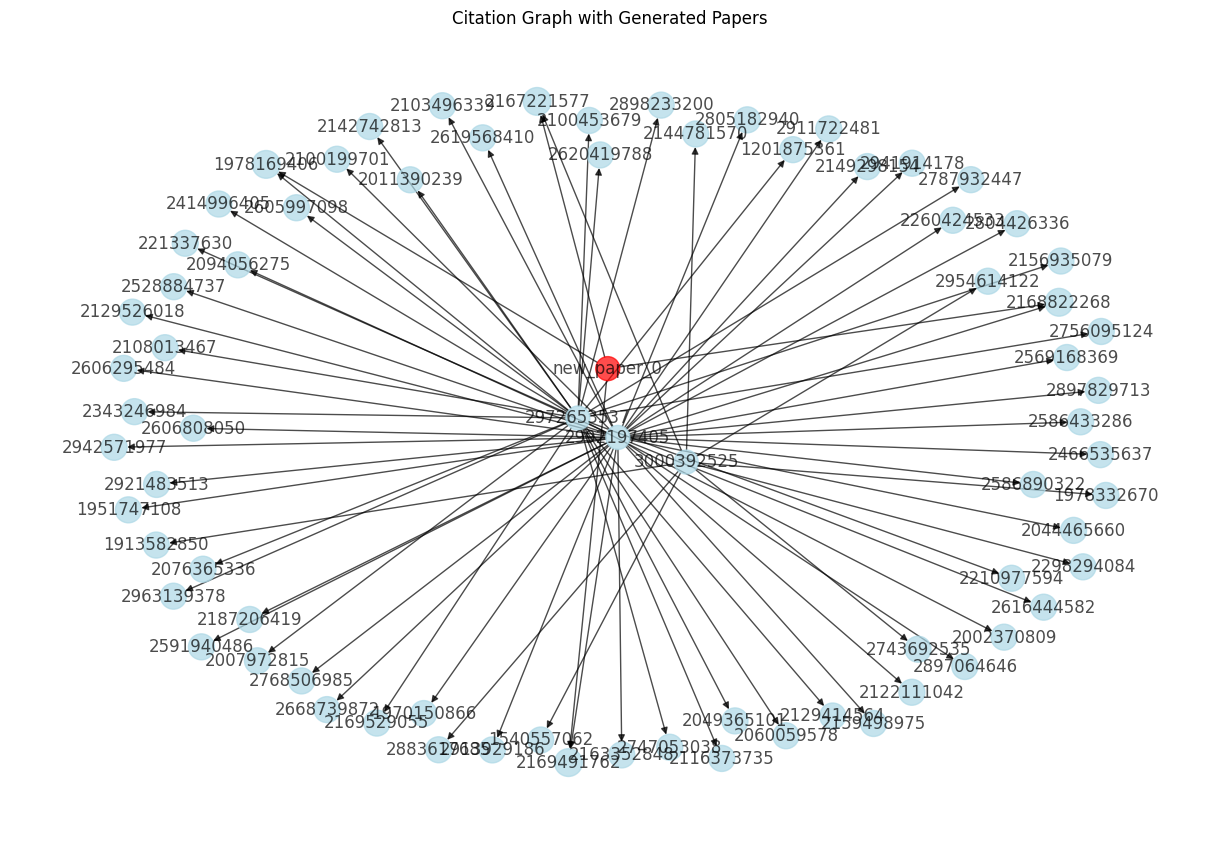

In [17]:
# Evaluate the abstract
metrics = generator.evaluate_abstract(new_node_id)
print("Evaluation Metrics:")
for metric, value in metrics.items():
    if isinstance(value, float):
        print(f"- {metric}: {value:.4f}")
    elif isinstance(value, list):
        print(f"- {metric}: {value}")
    else:
        print(f"- {metric}: {value}")

# Visualize the graph
generator.visualize_graph(highlight_node=new_node_id)

## With better abstract generated by llm

Evaluation Metrics:
- avg_similarity: 0.2709629535675049
- max_similarity: 0.3700120449066162
- min_similarity: 0.17191383242607117
- std_similarity: 0.09904910624027252
- num_linked_papers: 2
- avg_concept_similarity: 0.0000
- new_concepts_count: 7
- new_concepts_percentage: 1.0000
- new_concepts: ['insert', 'specific', 'element', 'element requires', 'element requires filled', 'filled', 'key']


## Without better abstract
Evaluation Metrics:
- avg_similarity: 0.8584064245223999
- max_similarity: 0.8661234378814697
- min_similarity: 0.8506894111633301
- std_similarity: 0.007717013359069824
- num_linked_papers: 2
- avg_concept_similarity: 0.0000
- new_concepts_count: 3
- new_concepts_percentage: 1.0000
- new_concepts: ['new', 'generation', 'generation students']

Evaluation Metrics:
- avg_similarity: 0.9999999403953552
- max_similarity: 0.9999999403953552
- min_similarity: 0.9999999403953552
- std_similarity: 0.0
- num_linked_papers: 1
- avg_concept_similarity: 0.6667
- new_concepts_count: 1
- new_concepts_percentage: 0.3333
- new_concepts: ['applications industry context']